In [1]:
import matplotlib
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats # For gaussian pdf
import cv2 as cv # For map generation

import collections
import math
import random
import collections.abc
import multiprocessing
import threading

np.seterr('raise');
EPSILON = 1e-7

In [2]:
def prob_normal_distribution(x, var):
    return scipy.stats.norm(0, math.sqrt(var)).pdf(x)

def prob_triangular_distribution(x, var):
    return max(0, 1 / math.sqrt(6 * var) - abs(x) / 6 / var)

def sample_normal_distribution(var):
    return random.gauss(0, math.sqrt(var))

def sample_triangular_distribution(var):
    stddev = math.sqrt(var)
    
    return math.sqrt(6) / 2 * (random.uniform(-stddev, stddev) + random.uniform(-stddev, stddev))

# Taken from Kalman Filter book
def normalize_angle(x):
    x = x % (2 * math.pi)
    if x > math.pi:
        x -= 2 * math.pi
        
    return x

def motion_model_velocity(x_t, u_t, x_, dt, prob, alphas):
    x, y, theta = x_
    x_, y_, theta_ = x_t
    v, w = u_t
    
    mu = 0.5 * ((x - x_) * math.cos(theta) + (y - y_) * math.sin(theta)) / ((y - y_) * math.cos(theta) - (x - x_) * math.sin(theta) + EPSILON)
    x_star = (x + x_) / 2 + mu * (y - y_)
    y_star = (y + y_) / 2 + mu * (x - x_)
    r_star = math.sqrt((x - x_star)**2 + (y - y_star)**2)
    delta_theta = math.atan2(y_ - y_star, x_ - x_star) - math.atan2(y - y_star, x - x_star)
    v_ = delta_theta / dt * r_star
    w_ = delta_theta / dt
    gamma = normalize_angle((theta_ - theta) / dt - w_)
    
    p_1 = prob(v - v_, alphas[0] * v**2 + alphas[1] * w**2)
    p_2 = prob(w - w_, alphas[2] * v**2 + alphas[3] * w**2)
    p_3 = prob(gamma, alphas[4] * v**2 + alphas[5] * w**2)
    
    return p_1 * p_2 * p_3

def sample_motion_model_velocity(u_t, x_, dt, sample, alphas):
    x, y, theta = x_
    v, w = u_t
    
    v_ = v + sample(alphas[0] * v**2 + alphas[1] * w**2)
    w_ = w + sample(alphas[2] * v**2 + alphas[3] * w**2)
    gamma = sample(alphas[4] * v**2 + alphas[5] * w**2)
    x_ = x - v_ / w_ * math.sin(theta) + v_ / w_ * math.sin(theta + w_ * dt)
    y_ = y + v_ / w_ * math.cos(theta) - v_ / w_ * math.cos(theta + w_ * dt)
    theta_ = normalize_angle(theta + w_ * dt + gamma * dt)
    
    return np.array([x_, y_, theta_])

def sample_motion_model_velocity_n(u_t, positions, dt, sample, alphas):
    x_s = []
    y_s = []
    theta_s = []
    for x_t in zip(*positions):
        x, y, theta = sample_motion_model_velocity(u_t, x_t, dt, sample, alphas)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return np.array(x_s), np.array(y_s), np.array(theta_s)

def motion_model_velocity_n(positions, u_t, prev_position, dt, prob, alphas):
    p_s = []
    for i in range(len(positions[0])):
        position = positions[0][i], positions[1][i], positions[2][i]
        p_s.append(motion_model_velocity(position, u_t, prev_position, dt, prob, alphas))
        
    return np.array(p_s)

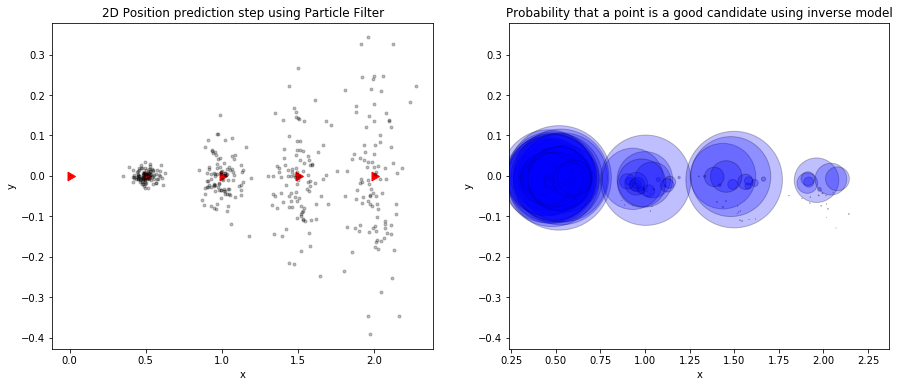

In [7]:
def simulate_predict_motion_model():
    DT = 0.5
    N_POINTS = 100
    N_EPOCH = 4

    u = np.array([1, 1e-6])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    alphas = [0.01] * 6
    no_noise_alphas = [0] * 6

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)

    perfect_model = np.zeros(3)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        x_s, y_s, theta_s = sample_motion_model_velocity_n(u, (x_s, y_s, theta_s), DT, sample, alphas)
        p_s = motion_model_velocity_n((x_s, y_s, theta_s), u, perfect_model, DT, prob, alphas)
        perfect_model = sample_motion_model_velocity(u, perfect_model, DT, sample, no_noise_alphas)
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=p_s * 200, alpha=0.25, c = 'b', edgecolors='k')

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_motion_model()

In [14]:
def motion_model_odometry(x_t, u_t, x_, prob, alphas):
    x, y, theta = x_
    x_, y_, theta_ = x_t
    delta_rot1, delta_trans, delta_rot2 = u_t
    
    delta_rot1_ = math.atan2(y_ - y, x_ - x) - theta
    delta_trans_ = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
    delta_rot2_ = theta_ - theta - delta_rot1_
    
    p1 = prob(
        normalize_angle(delta_rot1 - delta_rot1_),
        alphas[0] * delta_rot1_ ** 2 + alphas[1] * delta_trans_ ** 2
    )
    p2 = prob(
        delta_trans - delta_trans_,
        alphas[2] * delta_trans_ ** 2 + alphas[3] * (delta_rot1_ ** 2 + delta_rot2_ ** 2)
    )
    p3 = prob(
        normalize_angle(delta_rot2 - delta_rot2_),
        alphas[0] * delta_rot2_ ** 2 + alphas[1] * delta_trans_ ** 2
    )
    
    return p1 * p2 * p3

def sample_motion_model_odometry(u_t, x_, sample, alphas):
    x, y, theta = x_
    delta_rot1, delta_trans, delta_rot2 = u_t
    
    delta_rot1_ = delta_rot1 - sample(alphas[0] * delta_rot1 ** 2 + alphas[1] * delta_trans ** 2)
    delta_trans_ = delta_trans - sample(alphas[2] * delta_trans ** 2 + alphas[3] * (delta_rot1 ** 2 + delta_rot2 ** 2))
    delta_rot2_ = delta_rot2 - sample(alphas[0] * delta_rot2 ** 2 + alphas[1] * delta_trans ** 2)
    
    x_ = x + delta_trans_ * math.cos(theta + delta_rot1_)
    y_ = y + delta_trans_ * math.sin(theta + delta_rot1_)
    theta_ = normalize_angle(theta + delta_rot1_ + delta_rot2_)
    
    return x_, y_, theta_

def sample_motion_model_odometry_n(u_t, positions, sample, alphas):
    x_s = []
    y_s = []
    theta_s = []
    for position in zip(*positions):
        x, y, theta = sample_motion_model_odometry(u_t, position, sample, alphas)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return np.array(x_s), np.array(y_s), np.array(theta_s)

def motion_model_odometry_n(positions, u_t, prev_position, prob, alphas):
    p_s = []
    for i in range(len(positions[0])):
        position = positions[0][i], positions[1][i], positions[2][i]
        p_s.append(motion_model_odometry(position, u_t, prev_position, prob, alphas))
        
    return p_s

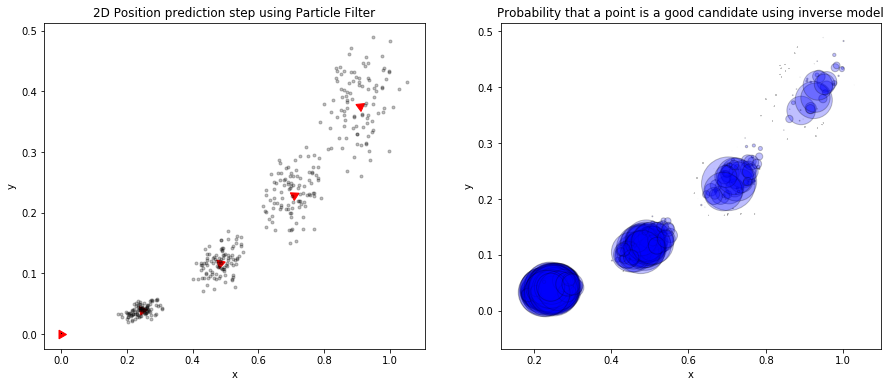

In [15]:
def simulate_predict_odometry_model():
    N_POINTS = 100
    N_EPOCH = 4

    u = np.array([math.pi / 20, 0.25, 0])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    alphas = [0.01] * 4
    no_noise_alphas = [0] * 4

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)

    perfect_model = np.zeros(3)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        x_s, y_s, theta_s = sample_motion_model_odometry_n(u, (x_s, y_s, theta_s), sample, alphas)
        p_s = motion_model_odometry_n((x_s, y_s, theta_s), u, perfect_model, prob, alphas)
        perfect_model = sample_motion_model_odometry(u, perfect_model, sample, no_noise_alphas)
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=p_s * 200, alpha=0.25, c = 'b', edgecolors='k')

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_odometry_model()

In [6]:
def prob_normal_distribution_clamped(x, stddev):
    ''' As to avoid underflow exceptions'''
    if abs(x) > 4 * stddev:
        return 0
    
    return prob_normal_distribution(x, stddev ** 2)

def pos_to_coord(x, y):
    ''' Inverted because we deal with images'''
    return int(round(y)), int(round(x))

def within_boundaries(m, i, j):
    ''' Inverted because we deal with images'''
    return i >= 0 and j >= 0 and i < m.shape[0] and j < m.shape[1]

def measurement_model_beam(x_t, m, z, z_max, stddev, d=0.5, res=0.01):
    x, y, theta = x_t
    x_, y_ = x, y
    dx = math.cos(theta)
    dy = math.sin(theta)
    ret = None
    while True:
        x_, y_ = x_ + dx *d, y_ + dy * d
        i, j = pos_to_coord(x_, y_)
        if not within_boundaries(m, i, j):
            ret = prob_normal_distribution_clamped(z - z_max, stddev)
            break
        
        dist = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
        if dist >= z_max:
            ret = prob_normal_distribution_clamped(z - z_max, stddev)
            break
        
        if m[i, j]:
            ret = prob_normal_distribution_clamped(z - dist, stddev)
            break
            
    return max(ret, res)

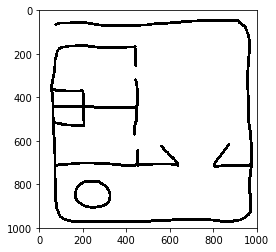

In [7]:
M = cv.imread('map.png', cv.IMREAD_GRAYSCALE).astype('float')
THRESH = 1
M[M <= THRESH] = 0.0
M[M > THRESH] = 1.0
M = 1 - M
MAP_SIZE = len(M)

plt.figure()
plt.imshow(1 - M, cmap='gray');

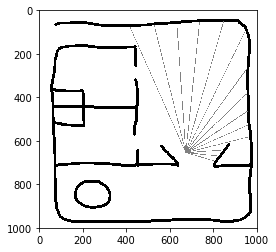

In [8]:
def raycast(pos, m, dist_max, d=0.25):
    x, y, theta = pos
    dx = math.cos(theta)
    dy = math.sin(theta)
    x_, y_ = x, y
    prev_pos = pos_to_coord(x_, y_)
    
    while True:
        x_, y_ = x_ + dx * d, y_ + dy * d
        i, j = pos_to_coord(x_, y_)
        
        if not within_boundaries(m, i, j) or math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2) > dist_max:
            return None
            
        if prev_pos != (i, j) and m[i, j] == 1:
            return x_, y_
        
        prev_pos = i, j
        
def simulate_raycast():
    DIST_MAX = MAP_SIZE
    STEP = 10
    FIELD = 135
    m_ = M.copy()
    x, y = random.randint(0.3 * MAP_SIZE, 0.7 * MAP_SIZE), random.randint(0.3 * MAP_SIZE, 0.7 * MAP_SIZE)
    theta = random.uniform(0, 2 * math.pi)
    plt.figure()
    for angle in range(-FIELD // 2, FIELD // 2, STEP):
        pos = x, y, theta + math.radians(angle)
        hit = raycast(pos, M, DIST_MAX)
        if hit:
            x_, y_ = int(hit[0]), int(hit[1])
            cv.line(m_, pos[:2], (x_, y_), 0.5, 2)

    plt.imshow(1 - m_, cmap='gray')

simulate_raycast()

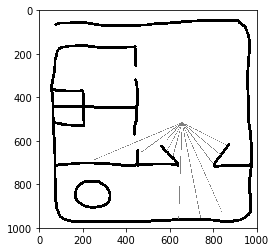

In [9]:
class Sensor:
    def __init__(self, field, n_rays, dist_max, sigma):
        self.field = field
        self.n_rays = n_rays
        self.dist_max = dist_max
        self.sigma = sigma
        self.scan_angles = [math.radians(angle) for angle in range(-self.field//2, self.field//2, self.field//self.n_rays)]
        
    def scan(self, pos, m, draw=False):
        x, y, theta = pos
        results = []
        for angle in self.scan_angles:
            dist = self._sense((x, y, theta + angle), m)
            if draw:
                x_, y_ = int(x + math.cos(theta + angle) * dist), int(y + math.sin(theta + angle) * dist)
                m = cv.line(m, (int(x), int(y)), (x_, y_), 0.1 if dist == self.dist_max else 0.5, 2)
                
            results.append(dist)
            
        return results
    
    def _sense(self, pos, m):
        hit = raycast(pos, m, self.dist_max)
        if hit is None:
            return self.dist_max
        
        x, y, _ = pos
        x_, y_ = hit
        dist = math.sqrt((x - x_) ** 2 + (y - y_) ** 2) + sample_normal_distribution(self.sigma ** 2)
        
        if dist < 0:
            return self.dist_max
        
        return dist
    
def simulate_sensor():
    DIST_MAX = 0.5 * MAP_SIZE
    N_RAYS = 10
    FIELD = 135
    SIGMA = 20
    sensor = Sensor(FIELD, N_RAYS, DIST_MAX, SIGMA)
    m_ = M.copy()
    x, y = random.randint(0.3 * MAP_SIZE, 0.7 * MAP_SIZE), random.randint(0.3 * MAP_SIZE, 0.7 * MAP_SIZE)
    theta = random.uniform(0, 2 * math.pi)
    sensor.scan((x, y, theta), m_, draw=True)
    plt.figure()
    plt.imshow(1 - m_, cmap='gray')
        
simulate_sensor()

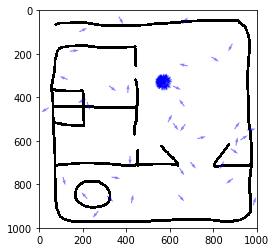

In [28]:
class MonteCarloLocalization:
    ANGLE_SPLIT = 4
    MIN_INIT_ROW = 5
    RATIO_NEW_PARTICLES = 0.25
    
    def __init__(self, m, n_particles, sensor, alphas, real_pos, alpha_fast=0.9, alpha_slow=0.1):
        self.m = m
        self.sensor = sensor
        self.alphas = alphas
        self.real_pos = real_pos
        self.w_slow = 1 / n_particles
        self.w_fast = 1 / n_particles
        self.alpha_fast = alpha_fast
        self.alpha_slow = alpha_slow
        
        self._populate_map(n_particles)
        self._filter_points()
        
    def _populate_map(self, n_particles):
        self.x_s = []
        self.y_s = []
        self.thetas = []
        self.weights = np.array([1 / n_particles] * n_particles)
        grid = np.linspace(0, MAP_SIZE, int(math.sqrt(n_particles // self.ANGLE_SPLIT)))
        if len(grid) >= self.MIN_INIT_ROW:
            self._populate_map_grid(grid)
            
        self._append_random_particles(n_particles - len(self.x_s))
            
    def _populate_map_grid(self, grid):     
        for x in grid:
            for y in grid:
                for theta in np.linspace(0, 2 * math.pi, self.ANGLE_SPLIT):
                    self.x_s.append(x)
                    self.y_s.append(y)
                    self.thetas.append(theta)
                    
        self.x_s = np.array(self.x_s)
        self.y_s = np.array(self.y_s)
        self.thetas = np.array(self.thetas)
        
    def _append_random_particles(self, n_particles):
        if n_particles:        
            x_s = np.random.rand(n_particles) * MAP_SIZE
            y_s = np.random.rand(n_particles) * MAP_SIZE
            thetas = (np.random.rand(n_particles) - 0.5) * 2 * math.pi

            self.x_s = np.append(self.x_s, x_s)
            self.y_s = np.append(self.y_s, y_s)
            self.thetas = np.append(self.thetas, thetas)
                
    def estimated_pose(self):
        x = y = 0
        for theta in self.thetas:
            x += math.cos(theta)
            y += math.sin(theta)
            
        return np.average(self.x_s), np.average(self.y_s), math.atan2(y, x)
    
    def _filter_points(self):
        for k, (x, y, theta) in enumerate(zip(self.x_s, self.y_s, self.thetas)):
            i, j = pos_to_coord(x, y)
            while i < 0 or j < 0 or i >= self.m.shape[0] or j >= self.m.shape[1] or self.m[i, j]:
                x = random.random() * self.m.shape[1]
                y = random.random() * self.m.shape[0]
                theta = random.random() * 2 * math.pi
                i, j = pos_to_coord(x, y)
                
            self.x_s[k] = x
            self.y_s[k] = y
            self.thetas[k] = theta
    
    def predict(self, u_t):
        real_pos = sample_motion_model_odometry(u_t, self.real_pos, sample_normal_distribution, [0] * 4)
        i, j = pos_to_coord(self.real_pos[0], self.real_pos[1])
        if self.m[i, j]:
            return
        self.real_pos = real_pos
        self.x_s, self.y_s, self.thetas = sample_motion_model_odometry_n(
            u_t,
            (self.x_s,self.y_s, self.thetas),
            sample_normal_distribution,
            self.alphas
        )
        
        self._filter_points()
        
    def _select_particles(self, new_particles_indexes):
        self.x_s = np.array([self.x_s[i] for i in new_particles_indexes])
        self.y_s = np.array([self.y_s[i] for i in new_particles_indexes])
        self.thetas = np.array([self.thetas[i] for i in new_particles_indexes])
        
    def _resample(self):
        self.weights /= np.sum(self.weights)
        average_weight = np.average(self.weights)
        self.w_slow += self.alpha_slow * (average_weight - self.w_slow)
        self.w_fast += self.alpha_fast * (average_weight - self.w_fast)
        ratio = max(self.RATIO_NEW_PARTICLES, max(0, 1 - self.w_fast / self.w_slow))
        n_new_particles = int(ratio * len(self.x_s))
        
        new_particles_indexes = np.random.choice(
            list(range(len(self.weights))),
            len(self.weights) - n_new_particles,
            p=self.weights
        )
        
        self._select_particles(new_particles_indexes)
        self._append_random_particles(n_new_particles)
    
    def update(self, draw=False):
        m_ = self.m.copy() if draw else self.m
        scan = self.sensor.scan(self.real_pos, m_, draw=draw)
        
        P = multiprocessing.cpu_count()
        n_particles_per_thread = int(round(len(self.x_s) / P))
        threads = []
        for p in range(P):
            i = p * n_particles_per_thread
            j = min(i + n_particles_per_thread, len(self.x_s))
            t = threading.Thread(target=self._update_inner, args=(scan, i, j))
            t.start()
            threads.append(t)
            
        for t in threads:
            t.join()
            
        self._resample()
        
        return m_
        
    def _update_inner(self, scan, i, j):
        for idx, (x, y, theta) in enumerate(zip(self.x_s[i:j], self.y_s[i:j], self.thetas[i:j])):
            p = 1
            for angle, dist in zip(self.sensor.scan_angles, scan):
                p *= measurement_model_beam(
                    (x, y, theta + angle),
                    self.m,
                    dist,
                    self.sensor.dist_max,
                    self.sensor.sigma
                )
            self.weights[i + idx] = p
    
def prepare_marker(orientation):
    return math.cos(-orientation), math.sin(-orientation)

def listify(x):
    if not isinstance(x, collections.abc.Iterable):
        return [x]
    
    return x

def simulate_monte_carlo_localization():
    mcl = MonteCarloLocalization(
        M,
        150,
        Sensor(360, 25, MAP_SIZE, 10),
        [0.01] * 4,
        (0.8 * MAP_SIZE, 0.2 * MAP_SIZE, math.radians(90))
    )
    D = 10
    T = 4
    cmds = [[T, D, 0]] * 30
    
    fig, ax = plt.subplots()
    ax.set_ylim((MAP_SIZE, 0))
    ax.set_xlim((0, MAP_SIZE))
    
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
    
    def init():
        ax.clear()
        return [ax.imshow(1 - mcl.m, cmap='gray')]
    
    def plot_arrows(x_s, y_s, thetas, **args):
        x_s = listify(x_s)
        y_s = listify(y_s)
        thetas = listify(thetas)

        orientations = [prepare_marker(theta) for theta in thetas]
        U = [orientation[0] for orientation in orientations]
        V = [orientation[1] for orientation in orientations]

        return ax.quiver(
            x_s,
            y_s,
            U,
            V,
            scale=25,
            **args,
        )
    
    def animate(i):
        if i % 2: # predict
            init()
            cmd = cmds[i // 2]
            mcl.predict((math.radians(cmd[0]), cmd[1], math.radians(cmd[2])))
            plot_arrows(*mcl.real_pos, color='r')
            return [plot_arrows(mcl.x_s, mcl.y_s, mcl.thetas, color='b', alpha=0.5)]

        ax.clear()
        m_ = mcl.update(draw=True)
        ax.imshow(1 - m_, cmap='gray')
        plot_arrows(mcl.x_s, mcl.y_s, mcl.thetas, color='b', alpha=0.5)
        plot_arrows(*mcl.real_pos, color='r')
        return [plot_arrows(*mcl.estimated_pose(), color='g')]
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=2 * len(cmds), interval=500, blit=True)
    
    return anim

anim = simulate_monte_carlo_localization()
anim.save("slam.gif", writer=animation.PillowWriter(fps=5))

In [11]:
# To be used for mapping
def measurement_model_beam_probabilistic(x_t, m, z, z_max, stddev, d=0.5):
    x, y, theta = x_t
    dx = math.cos(theta)
    dy = math.sin(theta)
    p = 1
    most_probable = prob_normal_distribution(1.5 * stddev, stddev ** 2)
    x_, y_ = x, y
    i, j = pos_to_coord(x_, y_)
    i_, j_ = i, j
    dist = 0

    while True:
        if not within_boundaries(m, i, j):
            break
        if dist >= z_max:
            q = p * prob_normal_distribution_clamped(z - z_max, stddev)
            most_probable = max(most_probable, q)
            break
        if (i_, j_) != (i, j):
            q = p * m[i, j] * prob_normal_distribution_clamped(z - dist, stddev)
            most_probable = max(most_probable, q)
            p *= 1 - q
            i_, j_ = i, j
            
        x_, y_ = x_ + dx *d, y_ + dy * d
        dist = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
        i, j = pos_to_coord(x_, y_)
        
    return most_probable